# P12_1 Choice of algorithm

In this notebook we will check the performance of 4 machine learning algorithms:

- K-Nearest-Neighbor
- K-Means
- Logistic regression
- Random forest

## Packages and data import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mp
import scipy as sp
import random
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.stats import bartlett
from scipy.stats import shapiro

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score

import sklearn as sk

In [2]:
pd.set_option('display.max_rows', 10)

In [3]:
data_billet=pd.read_csv('billets.csv',sep=";",decimal=".")

## III) Description est observation des variables

### 1) Vérification de NaN

In [4]:
Row_NA=data_billet[data_billet.isna().any(axis=1)]
Row_NA_index=Row_NA.index

### 2) Remplacement des NAN par Régression linéaire

In [5]:
Reg_lineaire = smf.ols('margin_low ~ diagonal+height_left+height_right+margin_up+length', data=data_billet).fit()
#print(reg_multi.summary())

In [6]:
prediction = round(Reg_lineaire.predict(Row_NA),2)

In [7]:
data_billet.loc[Row_NA.index,"margin_low"]=prediction
#data_billet.loc[Row_NA_index,]

### 3) Moyenne, écart-type, min, max ...

In [8]:
data_billet.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
mean,171.958440,104.029533,103.920307,4.483480,3.151473,112.67850
std,0.305195,0.299462,0.325627,0.659643,0.231813,0.87273
min,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000
max,173.010000,104.880000,104.950000,6.900000,3.910000,114.44000


### 4) Boxplot de chaque variable
Trouver le moyen de sauvegarder les graphiques dans un objet à partir d'une boucle /!\

In [9]:
def boxplot(column):
    sns.boxplot(x = "is_genuine", y = column,
                data = data_billet)

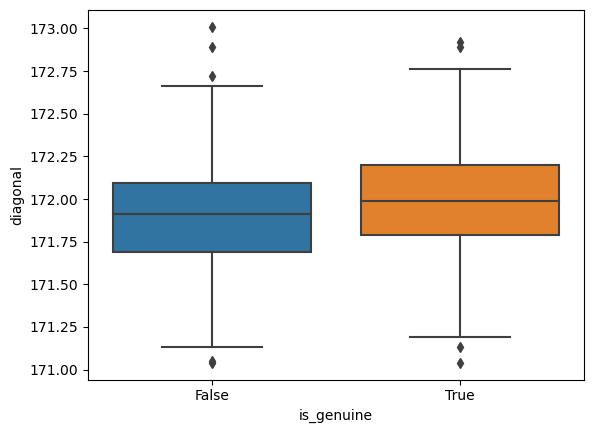

In [10]:
boxplot("diagonal")

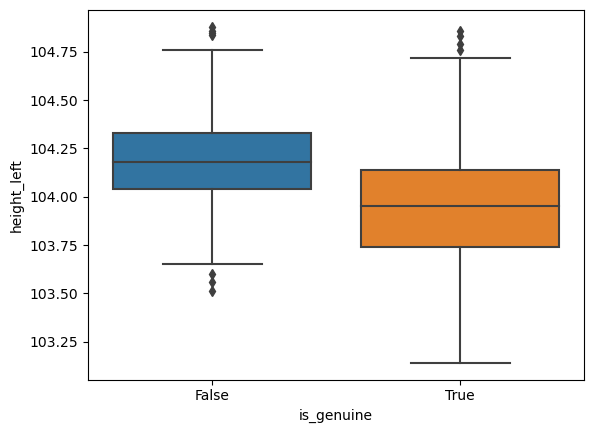

In [11]:
boxplot("height_left")

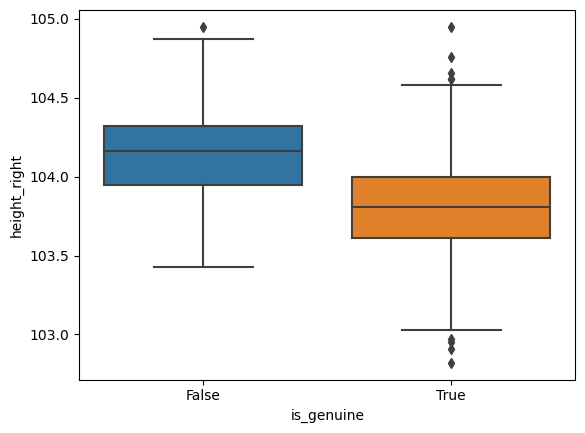

In [12]:
boxplot("height_right")

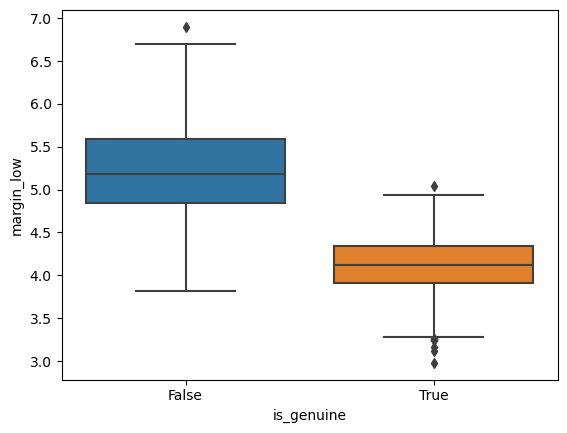

In [13]:
boxplot("margin_low")

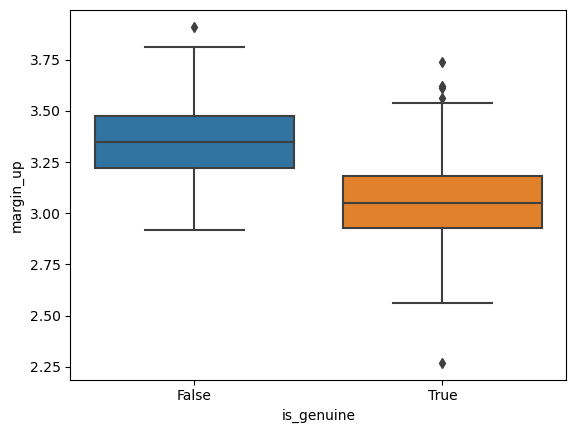

In [14]:
boxplot("margin_up")

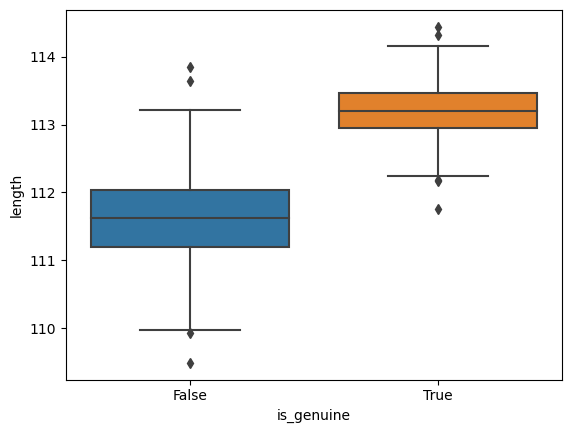

In [15]:
boxplot("length")

### 4) Histogramme de chaque variable

In [16]:
def hist(column):
    mp.pyplot.hist(data_billet[column])
    shapiro_test = sp.stats.shapiro(data_billet[column])
    if shapiro_test.pvalue>0.05:
        print("la p-value est de",shapiro_test.pvalue ,", on ne peut pas réfuter l'hypothèse H0:\"La variable suit une loi normale dans la population visée\" ")
    else:
        print("la p-value est de",shapiro_test.pvalue ,", on réfute l'hypothèse H0:\"La variable suit une loi normale dans la population visée\" ")

la p-value est de 0.32343590259552 , on ne peut pas réfuter l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


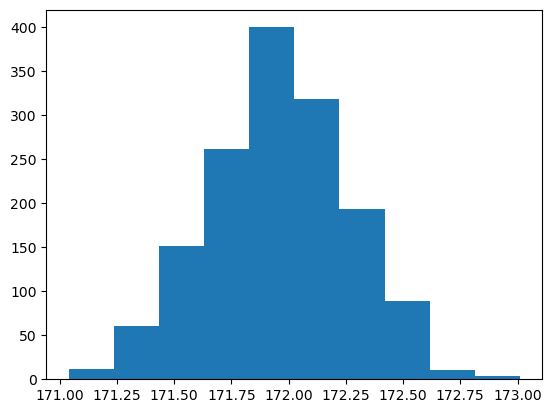

In [17]:
hist("diagonal")

la p-value est de 0.0509396530687809 , on ne peut pas réfuter l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


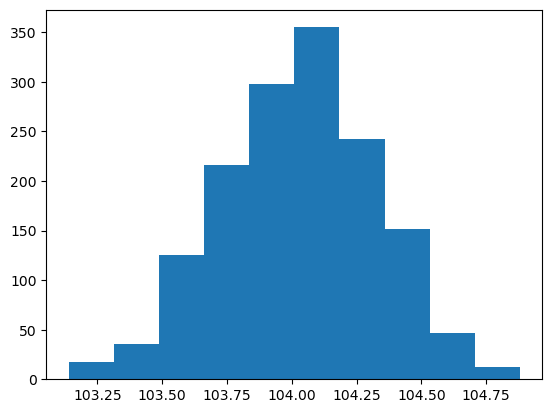

In [18]:
hist("height_left")

la p-value est de 0.9806053638458252 , on ne peut pas réfuter l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


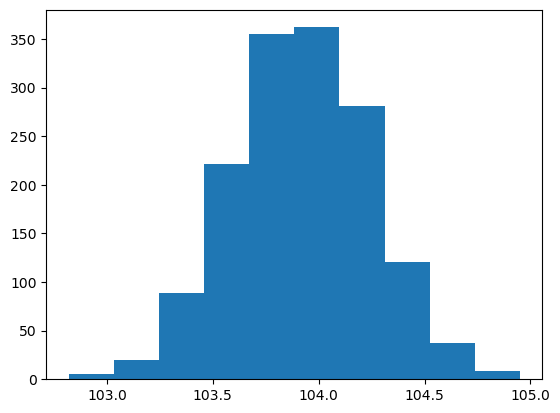

In [19]:
hist("height_right")

la p-value est de 1.2791498893370621e-24 , on réfute l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


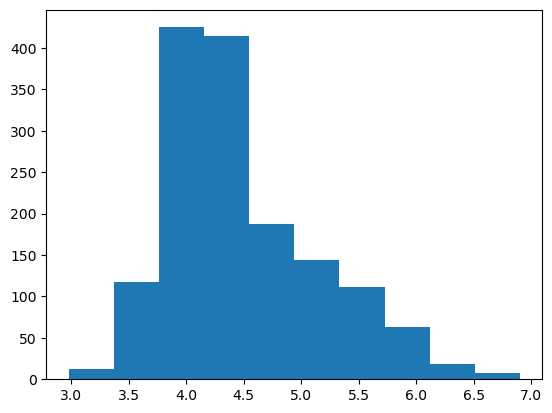

In [20]:
hist("margin_low")

la p-value est de 0.000810406228993088 , on réfute l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


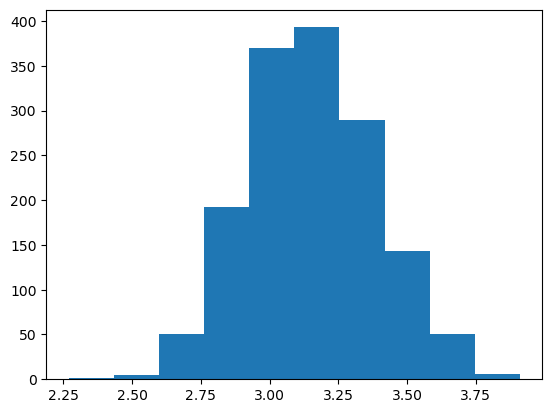

In [21]:
hist("margin_up")

la p-value est de 7.863947037789753e-28 , on réfute l'hypothèse H0:"La variable suit une loi normale dans la population visée" 


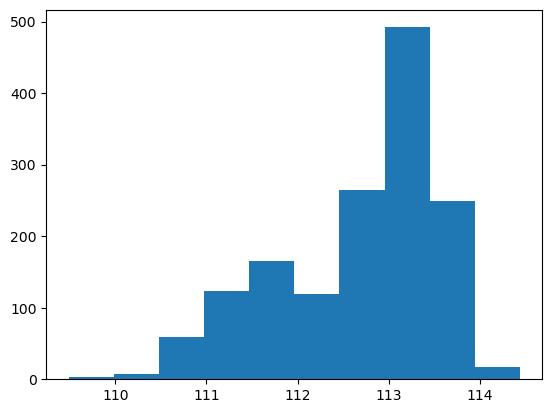

In [22]:
hist("length")

In [23]:
#Faire test de normalité et égalité des variances /!\
# shapiro pour petit échantillon /!\
# kolmokorof pour les gros échantillons /!\

## Test de normalité (Shapiro-Wilk)

In [24]:
#Prérequis:
def shapiro_test (data,column):
    tempo1=data.loc[data[data["is_genuine"]==True].index,column]
    tempo2=data.loc[data[data["is_genuine"]==False].index,column]
    return shapiro(tempo1),shapiro(tempo2) 

for i in data_billet.columns[data_billet.columns!="is_genuine"]:
    print(i, "True pvalue:", shapiro_test(data_billet,i)[0][1])
    print(i, "False pvalues:", shapiro_test(data_billet,i)[1][1])

diagonal True pvalue: 0.3102126121520996
diagonal False pvalues: 0.6387675404548645
height_left True pvalue: 0.028511906042695045
height_left False pvalues: 0.7906213998794556
height_right True pvalue: 0.5872448086738586
height_right False pvalues: 0.826613187789917
margin_low True pvalue: 0.4214468002319336
margin_low False pvalues: 0.5011724829673767
margin_up True pvalue: 0.3552444279193878
margin_up False pvalues: 0.1925809681415558
length True pvalue: 0.30358031392097473
length False pvalues: 0.526782214641571


## Test d'homogeneité des variances

In [25]:
#Prérequis:
def bartlette_test (data,column):
    tempo1=data.loc[data[data["is_genuine"]==True].index,column]
    tempo2=data.loc[data[data["is_genuine"]==False].index,column]
    return bartlett(tempo1,tempo2)
    

for i in data_billet.columns[data_billet.columns!="is_genuine"]:
    print(i,"pvalue:",bartlette_test(data_billet,i)[1])

diagonal pvalue: 0.5846911917435405
height_left pvalue: 2.8978873571016144e-13
height_right pvalue: 0.05981201390578732
margin_low pvalue: 4.323683969128672e-49
margin_up pvalue: 0.41310736619306765
length pvalue: 5.520465521419425e-47


## Donnée d'entraiment et Donnée de test


In [26]:
def train_test_data_fun (data):
    data_index=np.array(data.index)
    training_sample_index = np.random.choice(data_index,int(len(data_index)*0.8),replace=False)
    testing_sample_index=np.array(data_billet.index)[~np.isin(np.array(data.index),training_sample_index)]
    training_set = data.iloc[training_sample_index]
    testing_set = data.iloc[testing_sample_index]

    training_set_CR=training_set.loc[:, np.isin(list(Row_NA.columns),["is_genuine"],invert=True)]
    training_set_CR=StandardScaler().fit_transform(training_set_CR)
    training_set_CR=pd.DataFrame(training_set_CR,index=training_set.index,columns=training_set.columns[training_set.columns!="is_genuine"])
    training_set_CR["is_genuine"]=training_set["is_genuine"]

    testing_set_CR=testing_set.loc[:, np.isin(list(Row_NA.columns),["is_genuine"],invert=True)]
    testing_set_CR=StandardScaler().fit_transform(testing_set_CR)
    testing_set_CR=pd.DataFrame(testing_set_CR,index=testing_set.index,columns=training_set.columns[training_set.columns!="is_genuine"])
    testing_set_CR["is_genuine"]=testing_set["is_genuine"]
    
    training_set_CR_x= training_set_CR.iloc[:,training_set_CR.columns!='is_genuine']
    training_set_CR_y= training_set_CR.iloc[:,training_set_CR.columns=='is_genuine']
    testing_set_CR_x= testing_set_CR.iloc[:,testing_set_CR.columns!='is_genuine']
    testing_set_CR_y= testing_set_CR.iloc[:,testing_set_CR.columns=='is_genuine']
    return training_set_CR, training_set_CR_x ,training_set_CR_y, testing_set_CR, testing_set_CR_x, testing_set_CR_y

In [27]:
#np.random.seed()
np.random.seed(0) # permet de définir la seed

In [28]:
training_set_CR,training_set_CR_x,training_set_CR_y,testing_set_CR,testing_set_CR_x,testing_set_CR_y=train_test_data_fun (data_billet)

## Analyse exploratoire

#### Prérequis

In [29]:
#Centrage et réduction des données
data_billet_CR = StandardScaler().fit_transform(data_billet.iloc[:,data_billet.columns!="is_genuine"])
nb_ligne = data_billet.shape[0] #(nb ligne)
nb_colonne = data_billet.iloc[:,data_billet.columns!="is_genuine"].shape[1] #(nb colonne)

In [30]:
#Z = data_billet_CR
#X = data_billet
#coord = ACP_coord
#eigval = (n-1)/n*ACP.explained_variance_
#acp=ACP
#n = data_billet.shape[0] (nb ligne)
#p = data_billet.shape[1] (nb colonne)

#### ACP

In [31]:
ACP=PCA()
ACP_coord=ACP.fit_transform(data_billet_CR)

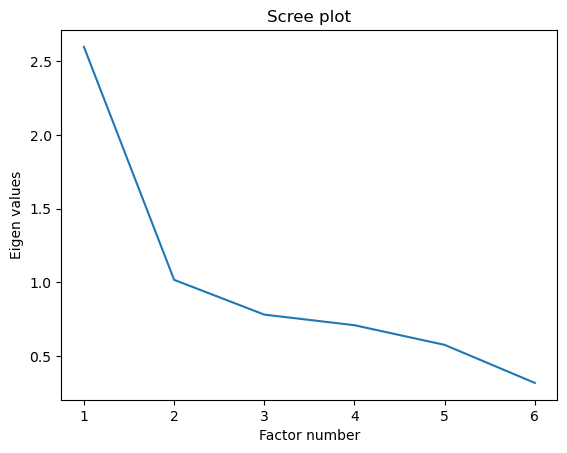

In [32]:
eigval = (nb_ligne-1)/nb_ligne*ACP.explained_variance_
mp.pyplot.plot(np.arange(1,nb_colonne+1),eigval)
mp.pyplot.title("Scree plot")
mp.pyplot.ylabel("Eigen values")
mp.pyplot.xlabel("Factor number")
mp.pyplot.show()

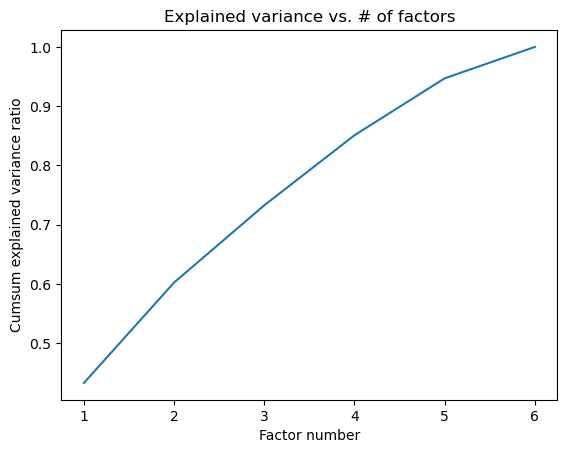

In [33]:
#cumul de variance expliquée
mp.pyplot.plot(np.arange(1,nb_colonne+1),np.cumsum(ACP.explained_variance_ratio_))
mp.pyplot.title("Explained variance vs. # of factors")
mp.pyplot.ylabel("Cumsum explained variance ratio")
mp.pyplot.xlabel("Factor number")
mp.pyplot.show()

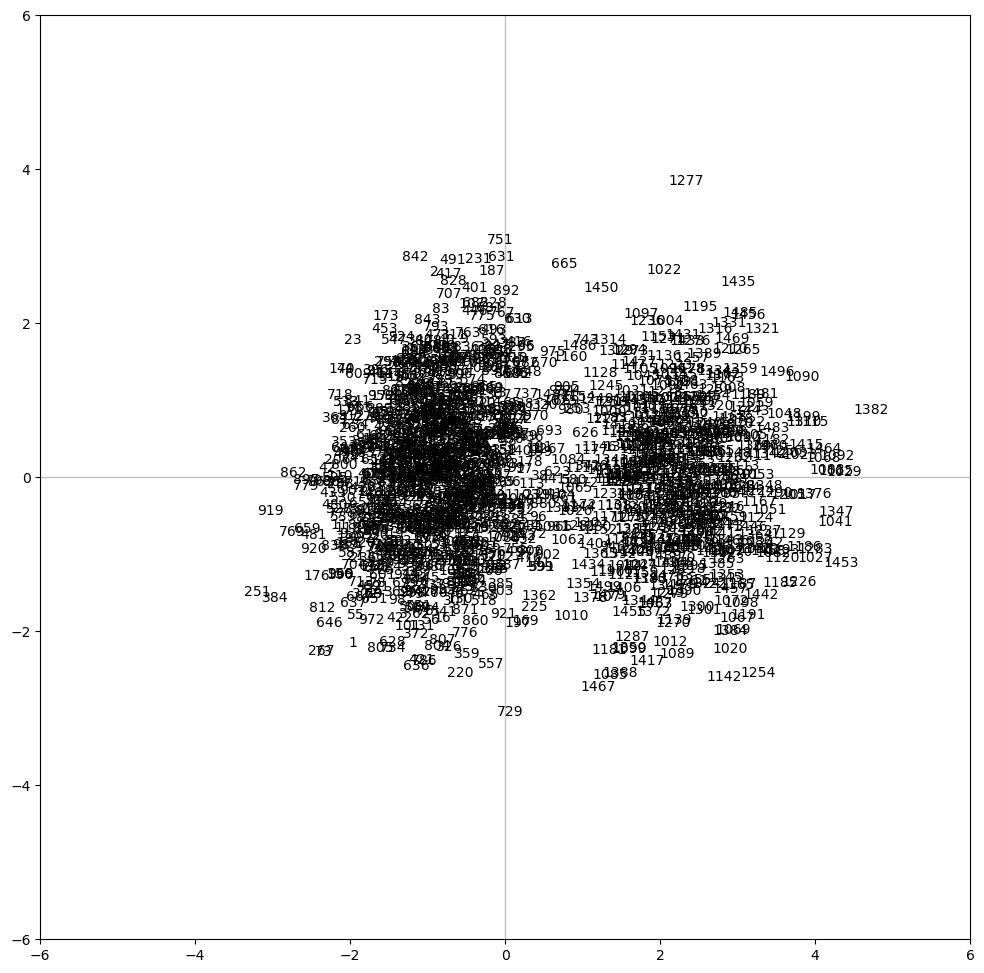

In [34]:
#positionnement des individus dans le premier plan
fig, axes = mp.pyplot.subplots(figsize=(12,12))
axes.set_xlim(-6,6) #même limites en abscisse
axes.set_ylim(-6,6) #et en ordonnée

#placement des étiquettes des observations
for i in range(nb_ligne):
 mp.pyplot.annotate(data_billet.index[i],(ACP_coord[i,0],ACP_coord[i,1]))

#ajouter les axes
mp.pyplot.plot([-6,6],[0,0],color='silver',linestyle='-',linewidth=1)
mp.pyplot.plot([0,0],[-6,6],color='silver',linestyle='-',linewidth=1)

#affichage
mp.pyplot.show()

In [35]:
#contribution des individus dans l'inertie totale
di = np.sum(data_billet_CR**2,axis=1)
print(pd.DataFrame({'ID':data_billet.index,'d_i':di}))

#qualité de représentation des individus - COS2
cos2 = ACP_coord**2
for j in range(nb_colonne):
 cos2[:,j] = cos2[:,j]/di
print(pd.DataFrame({'id':data_billet.index,'COS2_1':cos2[:,0],'COS2_2':cos2[:,1]}))

#contributions aux axes
ctr = ACP_coord**2
for j in range(nb_colonne):
 ctr[:,j] = ctr[:,j]/(nb_ligne*eigval[j])
print(pd.DataFrame({'id':data_billet.index,'CTR_1':ctr[:,0],'CTR_2':ctr[:,1]}))


        ID        d_i
0        0  19.244910
1        1  10.189300
2        2  10.834414
3        3   7.006278
4        4   5.747551
...    ...        ...
1495  1495   5.074892
1496  1496  13.295043
1497  1497   4.580553
1498  1498   4.092641
1499  1499   4.245019

[1500 rows x 2 columns]
        id    COS2_1    COS2_2
0        0  0.140457  0.029057
1        1  0.400428  0.478244
2        2  0.086815  0.633827
3        3  0.270822  0.471945
4        4  0.003848  0.055891
...    ...       ...       ...
1495  1495  0.400824  0.014333
1496  1496  0.808845  0.130634
1497  1497  0.779564  0.078663
1498  1498  0.782697  0.063857
1499  1499  0.255844  0.509970

[1500 rows x 3 columns]
        id     CTR_1     CTR_2
0        0  0.000694  0.000366
1        1  0.001047  0.003193
2        2  0.000241  0.004500
3        3  0.000487  0.002167
4        4  0.000006  0.000210
...    ...       ...       ...
1495  1495  0.000522  0.000048
1496  1496  0.002760  0.001138
1497  1497  0.000917  0.000236
1498

             id     COR_1     COR_2
0      diagonal -0.136484  0.949463
1   height_left  0.532856  0.310176
2  height_right  0.634249  0.109259
3    margin_low  0.818209 -0.073034
4     margin_up  0.708170 -0.005017
5        length -0.849410  0.049069


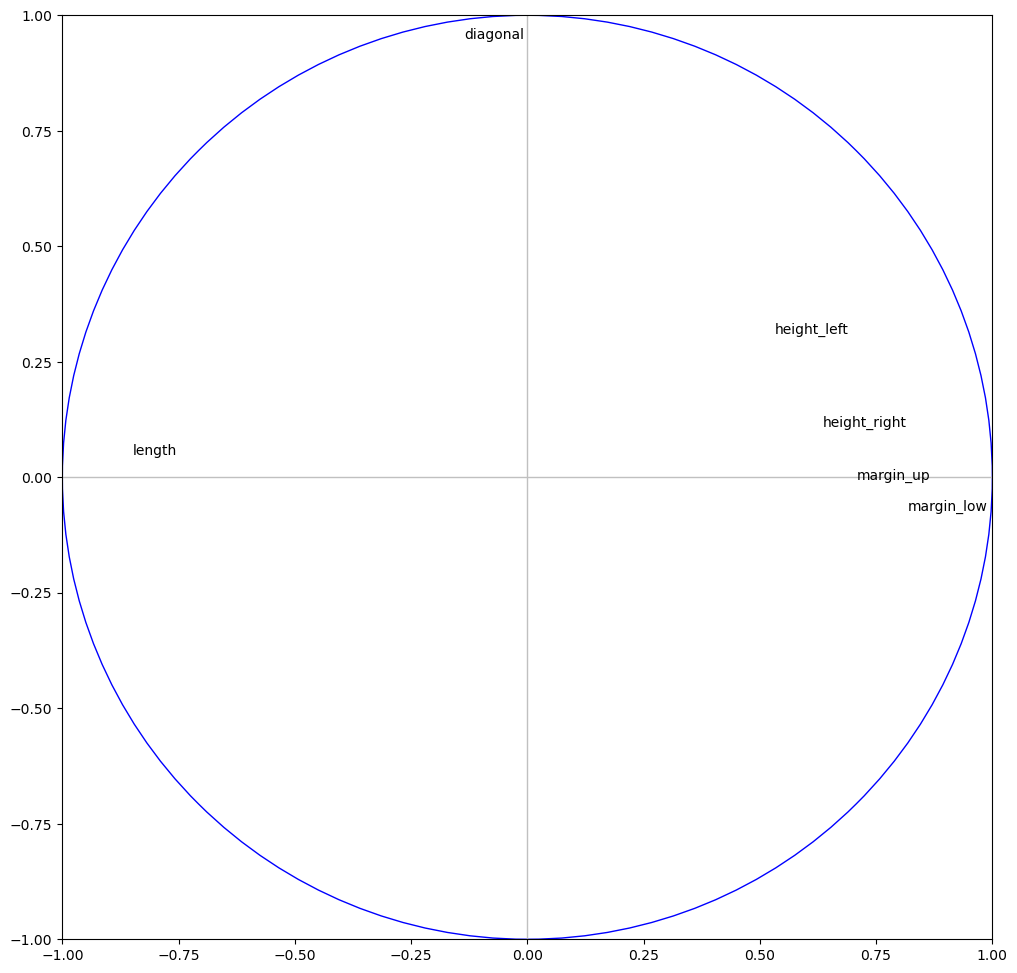

In [36]:
#valeur corrigée
eigval = (nb_ligne-1)/nb_ligne*ACP.explained_variance_

#racine carrée des valeurs propres
sqrt_eigval = np.sqrt(eigval)

#corrélation des variables avec les axes
corvar = np.zeros((nb_colonne,nb_colonne))
for k in range(nb_colonne):
 corvar[:,k] = ACP.components_[k,:] * sqrt_eigval[k]

#on affiche pour les deux premiers axes
print(pd.DataFrame({'id':data_billet.iloc[:,data_billet.columns!="is_genuine"].columns,'COR_1':corvar[:,0],'COR_2':corvar[:,1]}))
 
#cercle des corrélations
fig, axes = mp.pyplot.subplots(figsize=(12,12))
axes.set_xlim(-1,1)
axes.set_ylim(-1,1)
#affichage des étiquettes (noms des variables)
for j in range(nb_colonne):
 mp.pyplot.annotate(data_billet.iloc[:,data_billet.columns!="is_genuine"].columns[j],(corvar[j,0],corvar[j,1]))

#ajouter les axes
mp.pyplot.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
mp.pyplot.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

#ajouter un cercle
cercle = mp.pyplot.Circle((0,0),1,color='blue',fill=False)
axes.add_artist(cercle)
#affichage
mp.pyplot.show()

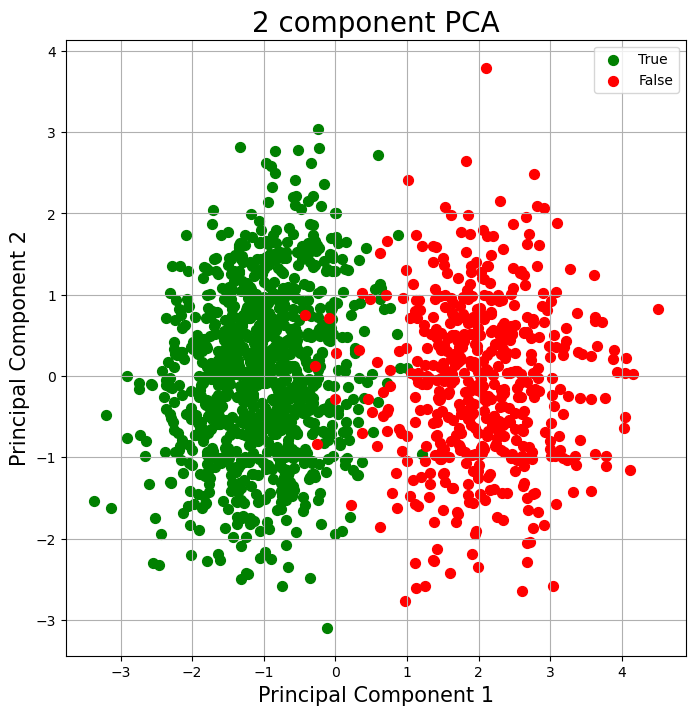

In [37]:
# représentation des deux groupes True False sur ACP 
ACP2=PCA(n_components=2)
ACP_coord2=ACP2.fit_transform(data_billet_CR)

principalDf = pd.DataFrame(data = ACP_coord2
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, data_billet[["is_genuine"]]], axis = 1)
fig = mp.pyplot.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [True, False]
colors = ['g', 'r']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['is_genuine'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

## Kmeans

In [38]:
#Calcul ACP
ACP2=PCA(n_components=2)
ACP_coord2=ACP2.fit_transform(data_billet_CR)

D:\data_science\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


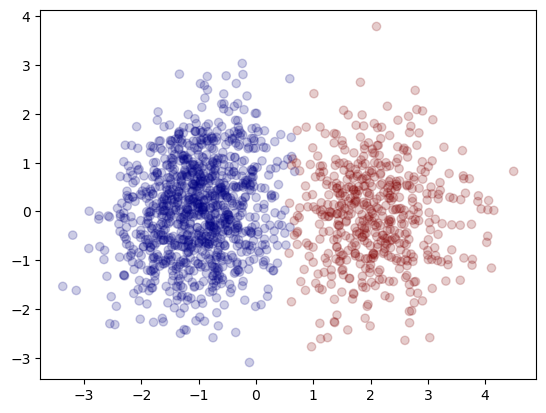

In [40]:
# Clustering par K-means
km = KMeans(n_clusters=2)
km_coord = km.fit(data_billet_CR)

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
mp.pyplot.scatter(ACP_coord2[:, 0], ACP_coord2[:, 1], c=clusters.astype(np.float64), cmap = 'jet', alpha=.2)
mp.pyplot.show(block=False)

In [41]:
# fitting
train_coord = ACP2.fit_transform(training_set_CR_x)
prediction_kmean = km.fit_predict(train_coord)  


# Prédiction
train_coord = ACP2.transform(testing_set_CR_x)
prediction_kmean = km.predict(train_coord)

D:\data_science\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [42]:
# liste de conditions
conditions = [(prediction_kmean == 0),(prediction_kmean==1)]
values = [False,True]
testing_set_CR['prediction_kmean'] = np.select(conditions, values)
testing_set_CR['prediction_kmean']=testing_set_CR['prediction_kmean'].astype(bool)

In [43]:
#Matrice de confusion
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_kmean"])

array([[ 93,   2],
       [  2, 203]], dtype=int64)

## Régression logistique (plutot Generalized Linear Models)

In [44]:
#calcule Régression logistique
regression_logistique=smf.glm('is_genuine ~ height_left+height_right+margin_low+margin_up+length', data=training_set_CR, family=sm.families.Binomial()).fit()
print(regression_logistique.summary())
print("r-square :" ,1-(regression_logistique.deviance/regression_logistique.null_deviance))

                             Generalized Linear Model Regression Results                             
Dep. Variable:     ['is_genuine[False]', 'is_genuine[True]']   No. Observations:                 1200
Model:                                                   GLM   Df Residuals:                     1194
Model Family:                                       Binomial   Df Model:                            5
Link Function:                                         Logit   Scale:                          1.0000
Method:                                                 IRLS   Log-Likelihood:                -34.537
Date:                                       Wed, 31 Jan 2024   Deviance:                       69.074
Time:                                               10:19:39   Pearson chi2:                 1.87e+03
No. Iterations:                                           10   Pseudo R-squ. (CS):             0.7051
Covariance Type:                                   nonrobust                      

In [45]:
#sélection des variables pour le calcul de la prédiction (testing)
regression_logistique_testing_set_CR=testing_set_CR[["height_left","height_right","margin_low","margin_up","length"]]

In [46]:
#prédiction
prediction_logi = round(regression_logistique.predict(regression_logistique_testing_set_CR),2)
pd.set_option('display.max_rows', 400)

In [47]:
#Mise en forme
conditions = [(prediction_logi <= 0.5),(prediction_logi >= 0.5)]
values = [True, False]
testing_set_CR['prediction_reg_log'] = np.select(conditions, values)
testing_set_CR['prediction_reg_log']=testing_set_CR['prediction_reg_log'].astype(bool)

In [48]:
#Matrice de confusion
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_reg_log"])

array([[ 93,   2],
       [  2, 203]], dtype=int64)

## Algorithme rondom forest

In [49]:
# rondom forest
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(training_set_CR_x,training_set_CR_y)
#score
print("r-squared :",clf.score(testing_set_CR_x,testing_set_CR_y))

#prédiction
y_pred=clf.predict(testing_set_CR_x)
testing_set_CR["prediction_rodom_forest"]=y_pred

D:\data_science\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


r-squared : 0.9933333333333333


In [50]:
#Matrice de confusion
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_rodom_forest"])

array([[ 94,   1],
       [  1, 204]], dtype=int64)

## KNN

In [51]:
#Instanciation et définition du KNN
knn = KNeighborsClassifier(n_neighbors = 2)
#training
knn.fit(training_set_CR_x,training_set_CR_y)
#score (Rsquare)
print("r-squared :",knn.score(testing_set_CR_x,testing_set_CR_y))
#Prédiction
prediction_KNN = knn.predict(testing_set_CR_x)
testing_set_CR["prediction_KNN"]=prediction_KNN

r-squared : 0.9833333333333333


D:\data_science\Lib\site-packages\sklearn\neighbors\_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [52]:
#Matrice de confusion
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_KNN"])

array([[ 94,   1],
       [  4, 201]], dtype=int64)

## Matice de confusion

In [53]:
#Kmeans
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_kmean"])

array([[ 93,   2],
       [  2, 203]], dtype=int64)

In [54]:
#Régression logistique
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_reg_log"])

array([[ 93,   2],
       [  2, 203]], dtype=int64)

In [55]:
#Rondom forest
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_rodom_forest"])

array([[ 94,   1],
       [  1, 204]], dtype=int64)

In [56]:
#KNN
confusion_matrix(testing_set_CR["is_genuine"], testing_set_CR["prediction_KNN"])

array([[ 94,   1],
       [  4, 201]], dtype=int64)

# Création du modèle final

In [57]:
#Le rondom forest semble être le plus fiable
# faire un entraînement sur toute les données cette fois

In [58]:
#data
data_billet_CR = StandardScaler().fit_transform(data_billet.iloc[:,data_billet.columns!="is_genuine"])
data_billet_CR_x=pd.DataFrame(data_billet_CR,index=data_billet.index,columns=data_billet.columns[data_billet.columns!="is_genuine"])
data_billet_CR_y=data_billet["is_genuine"]
# rondom forest
clf=RandomForestClassifier(n_estimators=100)
#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(data_billet_CR_x,data_billet_CR_y)

RandomForestClassifier()

In [59]:
# sauvegarde du model
pickle.dump(clf, open('finalized_model.sav', 'wb'))